# Relation between the number of database plasmids and prediction quality per species

Plots the number of database plasmids against precision, recall and F1 score (union version) for the reference-based methods HyAsP and MOB-recon.

Species:
 - Aeromonas veronii (A.v.)
 - Citrobacter freundii (C.f.)
 - Enterococcus faecium (E.f.)
 - Escherichia coli (E.c.)
 - Klebsiella aerogenes (K.a.)
 - Klebsiella oxytoca (K.o.)
 - Klebsiella pneumoniae (K.p.)
 - Salmonella enterica (S.e.)

For both databases and both tools: There was no clear correlation between the number of database plasmids and the prediction quality per species.

In [2]:
import math
import matplotlib.pyplot as plt
import os
import pandas as pd

from Bio import SeqIO

pd.options.display.max_rows = None

In [3]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df       


def get_scores(run, samples, test_samples):
    scores_per_sample = []

    for sample_id in samples:
        # evaluation files
        files = dict()
        files['HyAsP'] = '%s/sample_%i/eval/greedy/greedy_eval.csv' % (run, sample_id)
        files['MOB-recon'] = '%s/sample_%i/eval/mob_recon/mob_recon_eval.csv' % (run, sample_id)
        files['plasmidSPAdes'] = '%s/sample_%i/eval/plasmidspades/plasmidspades_eval.csv' % (run, sample_id)

        # reference information
        _, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(files['HyAsP'])
        num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

        total_length_refs = list_plasmids(files['HyAsP'], skip_ref_plasmids, num_ref_plasmids)['length (nt)'].sum()

        for tool in files:
            if os.path.isfile(files[tool]): 
                _, _, skip_pred_plasmids, skip_ref_by_pred, _, _, _, _, skip_summary_scores = parse_structure(files[tool])
                num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2

                total_length_preds = list_plasmids(files[tool], skip_pred_plasmids, num_pred_plasmids)['length (nt)'].sum()
                scores = list_scores(files[tool], skip_summary_scores, 3)
                recall = scores.iloc[0]['value']
                precision = scores.iloc[1]['value']
                f1_score = scores.iloc[2]['value']

                recalled_nt = int(recall * total_length_refs)
                precise_nt = int(precision * total_length_preds)
            else:
                total_length_preds = 0
                recall = 0
                precision = 0
                f1_score = 0
                recalled_nt = 0
                precise_nt = 0

            scores_per_sample.append([sample_id, tool, int(total_length_refs), int(total_length_preds), int(recalled_nt), int(precise_nt),
                                      recall, precision, f1_score])


    scores_per_sample = pd.DataFrame(scores_per_sample)
    scores_per_sample.rename(columns = {0: 'sample', 1: 'tool', 2: 'total_length_refs', 
                                        3: 'total_length_preds', 4: 'recalled_nt', 5: 'precise_nt',
                                        6: 'Recall', 7: 'Precision', 8: 'F1 score'}, inplace = True)
    
    aggregated_scores_per_org = []
    org_groups = test_samples.groupby('Organism')
    for org, group in org_groups:
        org_scores = scores_per_sample[scores_per_sample['sample'].isin(list(group['SampleId']))]
        tool_groups = org_scores.groupby('tool')
        for tool in ['plasmidSPAdes', 'HyAsP', 'MOB-recon']:
            grp = tool_groups.get_group(tool)
            total_precision = grp['precise_nt'].sum() / grp['total_length_preds'].sum() if grp['total_length_preds'].sum() > 0 else 0
            total_recall = grp['recalled_nt'].sum() / grp['total_length_refs'].sum() if grp['total_length_refs'].sum() > 0 else 0
            total_f1_score = 2 * (total_recall * total_precision) / (total_recall + total_precision) if total_recall + total_precision > 0 else 0
            aggregated_scores_per_org.append([org, tool, total_precision, total_recall, total_f1_score])
    aggregated_scores_per_org = pd.DataFrame(aggregated_scores_per_org)
    aggregated_scores_per_org.rename(columns = {0: 'Organism', 1: 'Tool', 2: 'Precision', 3: 'Recall', 4: 'F1 score'}, inplace = True)
    
    return scores_per_sample, aggregated_scores_per_org

In [4]:
# for some plasmids, the accession (of the GenBank file) does not correspond to (the locus name of) the sequence
# renaming to establish connection between plasmids in database file and plasmid table
renaming_map = {'PFAJ2600':'AF015088','COGAM330':'D00038','MA1PMA1':'D10841','PHIPPF1':'D10842','STMPSN22':'D14281',
                'MA2PMA2':'D17448','FVBPOAD2A':'D26094','SLMMTPMF':'D29637','BACPSTK1':'D29989','BACPHT926':'D43692',
                'VIBPSA19':'D85144','CE1CG13':'J01566','PT1CG':'J01764','HV2CG':'J03014','C30ORFR':'J03319',
                'CH1L1CG':'J03321','LBAPLJ1':'J04240','ECOORIASN':'K00826','NEUMTPLCG':'K03295','NT1NMRKAN':'L05392',
                'N43GENOME':'L09673','RJ2PRP':'L31578','OM1CG':'L31579','NB2REPN':'L38403','NEUFRA':'L42455',
                'WC1REPB':'L75827','MII2CG':'L77118','MII1CG':'L77119','JD1CG':'M10316','PNECG':'M12730','IM13CG':'M13761',
                'PNS1CG':'M16217','YSOSB2':'M18274','YSO1SM1':'M18275','PB0110CG':'M19465','STAPT48CG':'M19652',
                'PIJ101CG':'M21778','MYCADBCG':'M25059','RSFRMRA':'M28829','LS1CG':'M29725','PIP404CG':'M32882',
                'CLACG':'M37402','KYMCGREP':'M38574','PTITETLMOB':'M63891','RJ1REP':'M94552','PAU02482':'U02482',
                'BBU03641':'U03641','ECU10186':'U10186','RMU10426':'U10426','NGU20374':'U20374','APU20550':'U20550',
                'LRU21859':'U21859','RFU22411':'U22411','SPU23762':'U23762','LLU26594':'U26594','RAU30294':'U30294',
                'BFU30316':'U30316','PPU32369':'U32369','BSU32378':'U32378','BSU32379':'U32379','BSU32380':'U32380',
                'SIU36383':'U36383','SAU38428':'U38428','SAU38429':'U38429','SEU40259':'U40259','BBU43414':'U43414',
                'MMU47023':'U47023','PMU57647':'U57647','CMU59416':'U59416','EAU67194':'U67194','BTU67921':'U67921',
                'XFU71220':'U71220','TFU73041':'U73041','SLU74623':'U74623','MHU75508':'U75508','BLU76614':'U76614',
                'CLU77780':'U77780','MAU78295':'U78295','REU80928':'U80928','ECU81610':'U81610','SAU83488':'U83488',
                'APU83788':'U83788','CGU85507':'U85507','PAU88088':'U88088','SIU93082':'U93082','MAU94409':'U94409',
                'DGU94491':'U94491','SAU96609':'U96609','SAU96610':'U96610'}

## MOB-database

In [5]:
test_ids = list(pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database/test_ids.txt', header = None)[0])
sample_info = pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-05-23__MOB-suite_benchmark_reads/samples.csv', sep = ';')
sample_info['Organism'] = [' '.join(org.split(' ')[:2]) for org in sample_info.Organism]
test_samples = sample_info.loc[sample_info['SampleId'].isin(test_ids)]

run = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_mob_filtered'
samples = [1, 5, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44] \
        + [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 62, 63, 64, 65, 66, 76, 85, 86, 87, 102, 107, 108, 109, 110] \
        + [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 129, 133]

*Read prediction scores and aggregate them per species*

In [6]:
scores_per_sample, aggregated_scores_per_org = get_scores(run, samples, test_samples)

*Read database information*

In [7]:
plasmids_file_mob = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database_filtered/database_plasmids.fasta'
source_file_mob = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-05-23__MOB-suite_benchmark_reads/samples.csv'
id_file_mob = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database_filtered/test_ids.txt'
min_length = 500
max_length = math.inf

plasmids_mob = dict()
with open(plasmids_file_mob, 'r') as in_file:
    for record in SeqIO.parse(in_file, 'fasta'):
        if record.id in renaming_map:
            plasmids_mob[renaming_map[record.id]] = str(record.seq)
        else:
            plasmids_mob[record.id] = str(record.seq)

test_ids_mob = list(pd.read_csv(id_file_mob, header = None)[0])
sample_info_mob = pd.read_csv(source_file_mob, sep = ';')
sample_info_mob['Organism'] = [' '.join(org.split(' ')[:2]) for org in sample_info_mob['Organism']]
db_samples_mob = sample_info_mob.loc[~sample_info_mob['SampleId'].isin(test_ids_mob)]
for row in db_samples_mob.itertuples():
    db_samples_mob.at[row.Index, 'Plasmids'] = ','.join([acc for acc in row.Plasmids.split(',') if min_length <= len(plasmids_mob[acc]) <= max_length])


In [8]:
org_groups = db_samples_mob.groupby(['Organism'])
db_plasmids_per_org = dict()
for org, grp in org_groups:
    ids = []
    for i, row in grp.iterrows():
        ids += row['Plasmids'].split(',')
    db_plasmids_per_org[org] = ids

*Plot number of database plasmids against prediction quality*

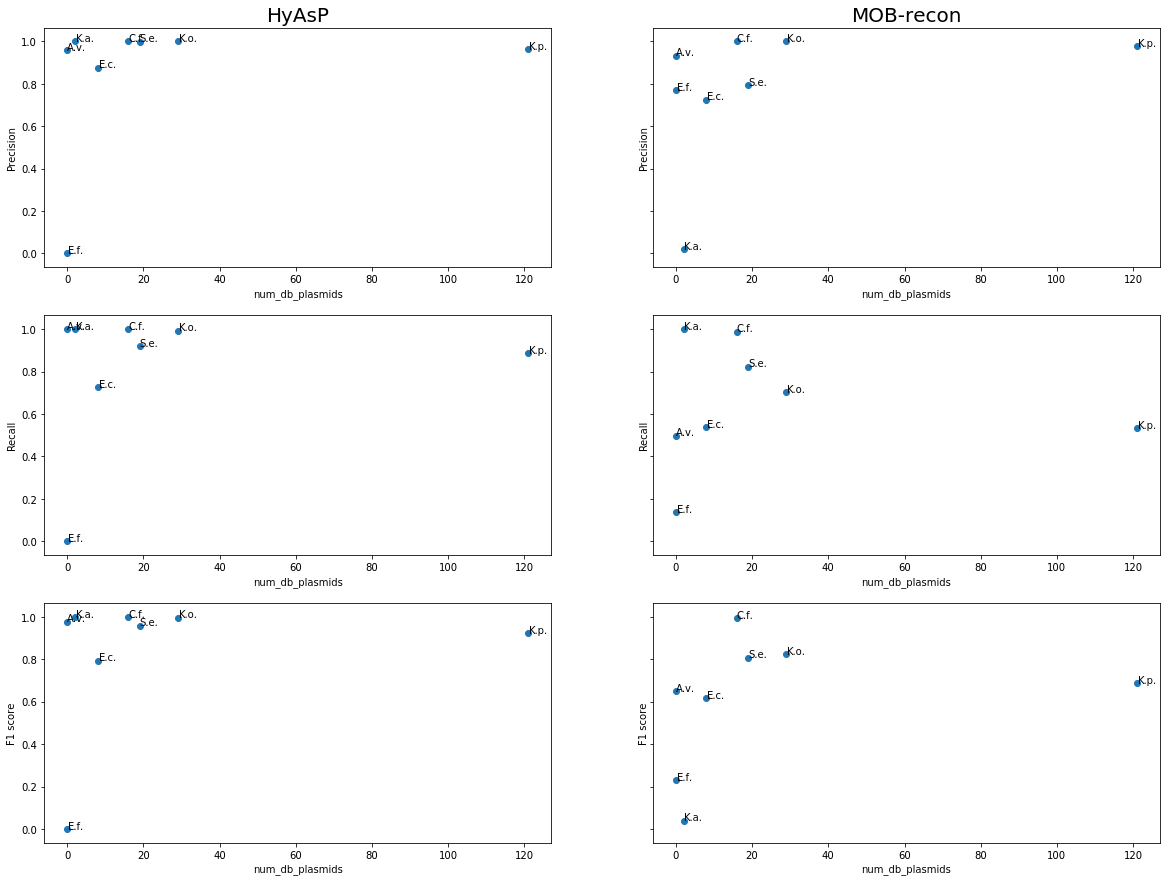

In [9]:
tools = ['HyAsP', 'MOB-recon']
metrics = ['Precision', 'Recall', 'F1 score']

fig, axes = plt.subplots(nrows = len(metrics), ncols = len(tools), figsize = (20,15), sharey = True)
for i in range(0, len(metrics)):
    for j in range(0, len(tools)):
        
        orgs = []
        num_plasmids = []
        scores = []

        df = aggregated_scores_per_org[aggregated_scores_per_org['Tool'] == tools[j]]

        for org in df['Organism']:
            orgs.append(org)
            num_plasmids.append(len(db_plasmids_per_org[org]) if org in db_plasmids_per_org else 0)
            scores.append(df.loc[df['Organism'] == org, metrics[i]].item())

        orgs_short = [('.'.join([token[0] for token in org.split(' ')]) + '.') for org in orgs]

        axes[i][j].scatter(num_plasmids, scores)
        for k, org in enumerate(orgs_short):
            axes[i][j].annotate(org, (num_plasmids[k], scores[k]))
            
        axes[i][j].set_xlabel('num_db_plasmids')
        axes[i][j].set_ylabel(metrics[i])
            
for j in range(0, len(tools)):
    axes[0][j].set_title(tools[j], fontsize = 20)

## NCBI-database

In [10]:
test_ids = list(pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database/test_ids.txt', header = None)[0])
sample_info = pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-05-23__MOB-suite_benchmark_reads/samples.csv', sep = ';')
sample_info['Organism'] = [' '.join(org.split(' ')[:2]) for org in sample_info.Organism]
test_samples = sample_info.loc[sample_info['SampleId'].isin(test_ids)]

run = '/project/6007976/wg-anoph/Plasmids-Assembly/exp/2018-10-29__analyses_greedy_paper/analysis_ncbi_filtered'
samples = [1, 5, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44] \
        + [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 62, 63, 64, 65, 66, 76, 85, 86, 87, 102, 107, 108, 109, 110] \
        + [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 129, 133]

*Read prediction scores and aggregate them per species*

In [11]:
scores_per_sample, aggregated_scores_per_org = get_scores(run, samples, test_samples)

*Read database information*

In [12]:
plasmids_file_ncbi = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/ncbi_database_filtered/database_plasmids.fasta'
source_file_ncbi = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/plasmids.csv'
released_before_ncbi = '2015-12-19T00:00:00Z'
db_type_ncbi = 'GenBank'
blacklist_ncbi = ['LN868944.1', 'LN868945.1', 'LN868946.1']
min_length = 500
max_length = math.inf

plasmids_ncbi = dict()
with open(plasmids_file_ncbi, 'r') as in_file:
    for record in SeqIO.parse(in_file, 'fasta'):
        if record.id in renaming_map:
            plasmids_ncbi[renaming_map[record.id]] = str(record.seq)
        else:
            plasmids_ncbi[record.id] = str(record.seq)

plasmid_table_ncbi = pd.read_csv(source_file_ncbi, sep = '\t')
plasmid_table_ncbi['#Organism Name'] = [' '.join(org.split(' ')[:2]) for org in plasmid_table_ncbi['#Organism Name']]
plasmid_table_ncbi['GenBankAcc'] = [entry.split(':')[-1].split('/')[-1] if entry[-1] != '/' else '' for entry in plasmid_table_ncbi['Replicons']]
plasmid_table_ncbi['RefSeqAcc'] = [entry.split(':')[-1].split('/')[0] if '/' in entry else '' for entry in plasmid_table_ncbi['Replicons']]
db_plasmids_ncbi = plasmid_table_ncbi.loc[plasmid_table_ncbi['Release Date'] < released_before_ncbi]
if db_type_ncbi in ['GenBank', 'both']:
    db_plasmids_ncbi = db_plasmids_ncbi.loc[~db_plasmids_ncbi['GenBankAcc'].isin(blacklist_ncbi)]
if db_type_ncbi in ['RefSeq', 'both']:
    db_plasmids_ncbi = db_plasmids_ncbi.loc[~db_plasmids_ncbi['RefSeqAcc'].isin(blacklist_ncbi)]
flags = []
for row in db_plasmids_ncbi.itertuples():
    flag = False
    if db_type_ncbi in ['GenBank', 'both']:
        name = row.GenBankAcc[:row.GenBankAcc.find('.')]
        flag = (name in plasmids_ncbi) and (min_length <= len(plasmids_ncbi[name]) <= max_length)
    if db_type_ncbi in ['RefSeq', 'both']:
        name = row.RefSeqAcc[:row.RefSeqAcc.find('.')]
        flag = flag or ((name in plasmids_ncbi) and (min_length <= len(plasmids_ncbi[name]) <= max_length))
    flags.append(flag)
db_plasmids_ncbi = db_plasmids_ncbi[flags]

In [13]:
org_groups = db_plasmids_ncbi.groupby(['#Organism Name'])
db_plasmids_per_org = dict()
for org, grp in org_groups:
    db_plasmids_per_org[org] = list(grp['GenBankAcc'])

*Plot number of database plasmids against prediction quality*

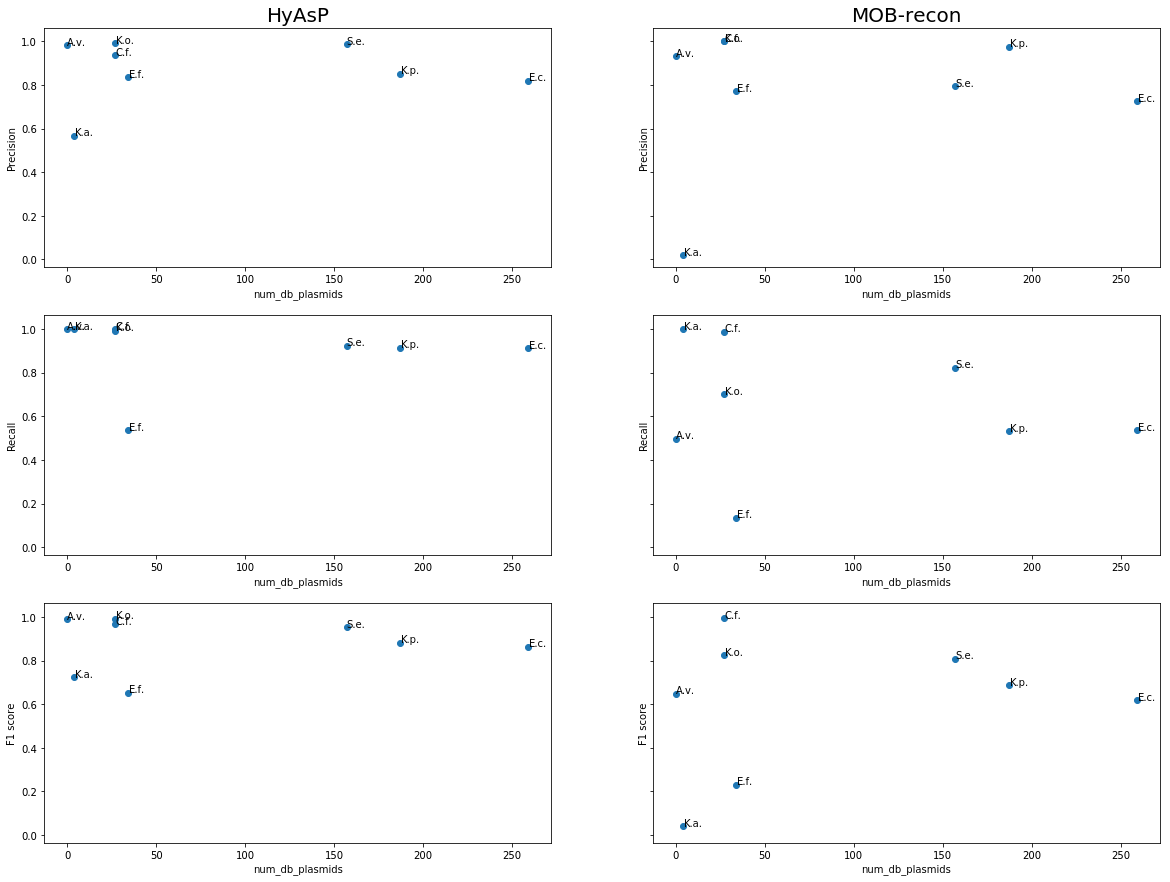

In [14]:
tools = ['HyAsP', 'MOB-recon']
metrics = ['Precision', 'Recall', 'F1 score']

fig, axes = plt.subplots(nrows = len(metrics), ncols = len(tools), figsize = (20,15), sharey = True)
for i in range(0, len(metrics)):
    for j in range(0, len(tools)):
        
        orgs = []
        num_plasmids = []
        scores = []

        df = aggregated_scores_per_org[aggregated_scores_per_org['Tool'] == tools[j]]

        for org in df['Organism']:
            orgs.append(org)
            num_plasmids.append(len(db_plasmids_per_org[org]) if org in db_plasmids_per_org else 0)
            scores.append(df.loc[df['Organism'] == org, metrics[i]].item())

        orgs_short = [('.'.join([token[0] for token in org.split(' ')]) + '.') for org in orgs]

        axes[i][j].scatter(num_plasmids, scores)
        for k, org in enumerate(orgs_short):
            axes[i][j].annotate(org, (num_plasmids[k], scores[k]))
            
        axes[i][j].set_xlabel('num_db_plasmids')
        axes[i][j].set_ylabel(metrics[i])
            
for j in range(0, len(tools)):
    axes[0][j].set_title(tools[j], fontsize = 20)